# Here, the questions are addressed:

- How to automatically find families of elements?

- How such families evolve over history?

# Data we have so far (from previous notebook):

- Similarity Matrix between Chemical Elements for every year (1800-2021).
- 50 near-optimal permutations of the elements, for each Similarity Matrix.

In [1]:
import sys
sys.path.append('../similarity')
sys.path.append('../Genetic1D')
from simMat import *
from genetic1D import *

import pickle
import cv2
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,12)
cmap=cm.get_cmap("jet")


rootPath = '../'

# Load similarity matrices
simMat_yr = np.load(rootPath + 'Data/simMat.npy',allow_pickle=True)
min_yr = 1800

# Load element list
elemList = getElemList(rootPath + 'Data/')

# Load optimized permutations
fh = open(rootPath + 'Results/optim_permut_yearly.gen', 'rb') 
Indivs_yr = pickle.load(fh)

# <font color=red>First</font>. Use the properties of the reshuffled matrix: 

## Families of elements will be regarded as sets of elements that the optimization algorithm tend to place in nearby positions in permutations.

The algorithm, built around a CV pipeline for shape detection in images, is shortly explained in the paper. It is further illustrated here with code and examples.

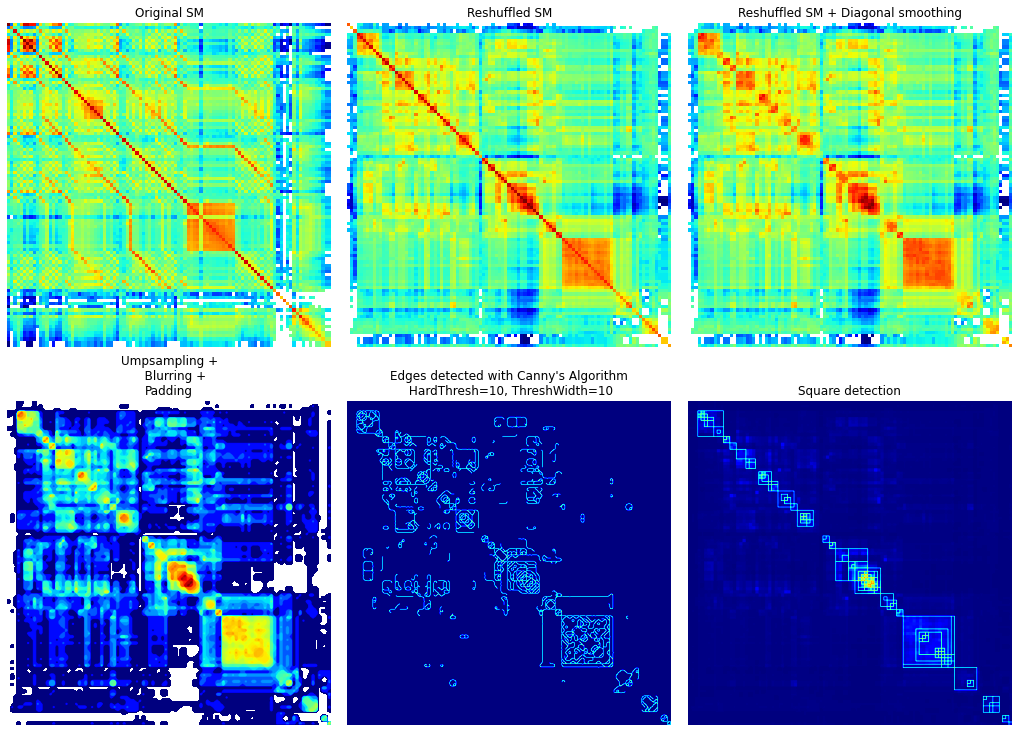

In [2]:
def CVP(Y, ind, US_FACT, blur_sz, th, b, max_grp=20, show=False):
    """
    Computer Vision Pipeline developed for detection of families of elements in similarity matrices.
    Parameters:
        Y: Year to consider
        ind: index of the particular permutation to consider
        US_FACT: Upsampling factor
        blur_sz: Size of blurring kernel
        th: Hard Threshold (Canny's algorithm)
        b: Threshold Width (Canny's algorithm)
    """
    
    if show:
        fig, ax = plt.subplots(2,3,figsize=(18,13),gridspec_kw={'wspace':0.05,'hspace':0.15})
        ax = ax.ravel()
        for i in range(len(ax)):
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            for spine in ['top','bottom','left','right']:
                ax[i].spines[spine].set_visible(False)

        def PlotStepImg(axi,img,title,log=True):
            # Plot all images using same cmap and normalization
            axi.set_title(title)
            if log: norm=LogNorm()
            else: norm=None
            axi.imshow(img,cmap=cmap,norm=norm)


    # Get similarity matrix for year Y
    P = plot_simMat_yr(simMat_yr,Y,min_yr=min_yr,
                       raw=False,scale=15,
                       show=False,EL=elemList)

    if show:        PlotStepImg(ax[0],P,'Original SM')

    # Get reshuffled matrix, using `ind`th permutation found for this year.
    P_reshuff = plot_simMat_yr(simMat_yr,Y,min_yr=min_yr,
                               raw=False,scale=15,
                               ordering=Indivs_yr[Y][ind],
                               show=False,EL=elemList)
    if show:        PlotStepImg(ax[1],P_reshuff,'Reshuffled SM')

    # Set diagonal elements equal to avg of sorroundings, so edge is clearer
    idx = np.diag_indices(P.shape[0]-1)
    P_reshuff[idx] = (P_reshuff[idx[0],idx[1]+1] + P_reshuff[idx[0],idx[1]-1])/2

    if show:        PlotStepImg(ax[2],P_reshuff,'Reshuffled SM + Diagonal smoothing')

    # Convert matrix values into integers in range 0-255
    img = np.rint(((P_reshuff/np.max(P))*255)).astype(np.uint8)

    # Upsample: Increase num. pixels by duplicating each pixel locally
    upsamp = cv2.resize(img,dsize=(img.shape[0]*US_FACT,img.shape[1]*US_FACT),
                        interpolation=cv2.INTER_NEAREST)  

    # Blur operation. Avg to fade some spurious edges
    blur = cv2.medianBlur(upsamp, blur_sz)

    # Add padding, so the image is framed and groups to the edges can be detected
    padd = cv2.copyMakeBorder(blur, 1,1,1,1, cv2.BORDER_CONSTANT, None, 0)

    if show:        PlotStepImg(ax[3],padd,'Umpsampling +\n   Blurring +\nPadding')

    # Detect edges with Canny algorithm
    canny = cv2.Canny(padd, th , th + b)
    if show:        PlotStepImg(ax[4],canny,log=False,
                    title=f"Edges detected with Canny\'s Algorithm\n HardThresh={th}, ThreshWidth={b}")


    # Find rectangles
    cnts = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)[0]

    cp=upsamp.copy()
    final_cnts = []
    for c in cnts:  # Loop through found contours
        x,y,w,h = cv2.boundingRect(c)
        # Conditions: Square on the diagonal, below certain size, above certain size
        if x==y and w < max_grp*US_FACT and w > US_FACT:
            final_cnts.append(c)
            
            if show:
                # Draw rectangles on image
                cv2.rectangle(cp, 
                              (x//US_FACT *US_FACT, y//US_FACT *US_FACT),
                             ((x + w)//US_FACT *US_FACT, (y + h)//US_FACT *US_FACT),
                              (255,0,0), 1)

    if show:        PlotStepImg(ax[5],cp,'Square detection',log=False); plt.show()
    return final_cnts


# Input parameters:
Y = 2021
ind = 1
US_FACT = 10
blur_sz = 13
th=10
b=10
max_grp=20

final_cnts = CVP(Y, ind, US_FACT, blur_sz, th, b, max_grp, show=True)

# That's what the CV processing pipeline looks like.

## Let's now see what the actual output groups look like.

In [3]:
def genToElem(gen):
    """
    func to convert a gen (list of positions) into sequence of reshuffled elements
    """
    order = ['_' for i in range(len(gen))]
    for i,idx in enumerate(gen):
        order[idx] = elemList[i]
    return order

def GetFEsCVP(Y, ind, final_cnts):
    """
    Post-process results from CVP. Convert raw info from squares, into FEs.
    """
    
    # Get similarity matrix for year Y, ordered with `ind`th permutation
    P = plot_simMat_yr(simMat_yr,Y,min_yr=min_yr,
                       raw=False,scale=15,
                       ordering=Indivs_yr[Y][ind],
                       show=False,EL=elemList)
    
    # Now let's extract the actual groups from the squares
    seq = genToElem(Indivs_yr[Y][ind])
    grps = {} # Do as a dict so repeated entries are not added

    covered = np.ones(P.shape[0])  # Array to store which positions have been covered
    for c in final_cnts:  # Loop through found rectangles
        x,y,w,h = cv2.boundingRect(c)
        st = seq[x//US_FACT:x//US_FACT+w//US_FACT]  # Add mins and maxs to include border of square too

        covered[x//US_FACT:x//US_FACT+w//US_FACT] = 0  # These positions are covered already
        # Add group only if it contains more than one element
        if len(set(st))>1:  
            grps[str(set(st))] = set(st)

    # Now form groups of consecutive elements that aren't covered by any square
    p = np.array(seq[:P.shape[0]])[covered.astype(bool)]

    c,count=0,False
    lens=[]
    for d in np.diff(covered):
        if d==1:      c+=1; count=True
        if d==0 and count:  c+=1
        if d==-1: lens.append(c); c=0; count=False

    cum=0
    for l in lens:
        if l>1:
            st=p[cum:cum+l]
            grps[str(set(st))] = set(st)
        cum+=l

    fams = list(grps.values())
    return fams


fams = GetFEsCVP(Y, ind, final_cnts)
print(f"Using the following list of parameters:\n\
        Upsampling Factor       = {US_FACT}\n\
        Size of blurring kernel = {blur_sz}\n\
        Hard Threshold  (Canny) = {th}\n\
        Threshold width (Canny) = {b}\n\
        Maximum Family Size     = {max_grp}\n\
      ")
print(f"A total of {len(fams)} families of elements were found for year {Y} using {ind}th permutation.")

Using the following list of parameters:
        Upsampling Factor       = 10
        Size of blurring kernel = 13
        Hard Threshold  (Canny) = 10
        Threshold width (Canny) = 10
        Maximum Family Size     = 20
      
A total of 51 families of elements were found for year 2021 using 1th permutation.


### Let's see which families were found

In [4]:
fams

[{'Fm', 'Md'},
 {'Ar', 'Xe'},
 {'Ar', 'He', 'Kr', 'Ne', 'Xe'},
 {'Ar', 'He', 'Ne'},
 {'Np', 'Pu'},
 {'Am', 'Cf', 'Cm', 'Es', 'Np', 'Pm', 'Pu'},
 {'Er', 'Lu', 'Y'},
 {'Dy', 'Er', 'Ho'},
 {'Eu', 'Ho', 'Nd', 'Tb', 'Tm', 'Yb'},
 {'Eu', 'Nd'},
 {'Dy', 'Er', 'Eu', 'Gd', 'Ho', 'Nd', 'Tb', 'Tm', 'Y', 'Yb'},
 {'Ce',
  'Dy',
  'Er',
  'Eu',
  'Gd',
  'Ho',
  'La',
  'Lu',
  'Nd',
  'Pr',
  'Sm',
  'Tb',
  'Tm',
  'Y',
  'Yb'},
 {'Ce',
  'Dy',
  'Er',
  'Eu',
  'Gd',
  'Ho',
  'La',
  'Lu',
  'Nd',
  'Pr',
  'Sc',
  'Sm',
  'Tb',
  'Tm',
  'Y',
  'Yb'},
 {'Nb', 'Ta'},
 {'Ga', 'In'},
 {'Al', 'Ga', 'In'},
 {'Bi', 'In', 'V'},
 {'C', 'H', 'O'},
 {'H', 'O'},
 {'H', 'N', 'O'},
 {'F', 'H', 'N', 'O'},
 {'F', 'N'},
 {'C', 'F', 'H', 'N', 'O', 'S'},
 {'Br', 'C', 'F', 'H', 'N', 'O', 'S'},
 {'Cl', 'I'},
 {'Br', 'Cl', 'F', 'H', 'I', 'N'},
 {'As', 'B', 'P'},
 {'As', 'B', 'Br', 'Cl', 'F', 'H', 'I', 'N', 'P', 'Sb'},
 {'Ir', 'Rh'},
 {'Re', 'Tc'},
 {'Ca', 'Mg'},
 {'Ba', 'Ca', 'Sr'},
 {'Ba', 'Sr'},
 {'Ba', 'Ca', 'Mg

# The results depend on the given parameters (4 in total, ignoring max family size). 

As explained in the paper, this Computer Vision Pipeline (CVP) is only a small, but fundamental part of the whole algorithm for generation of families of elements, as can be seen in the figure. CVP is applied in step $\textbf{b}$.


<img src="application_R.png">


As can be seen, CVP is applied several times to the same image, although with a different set of parameters each time. 

### We performed various experiments, and concluded that the following conditions produce acceptable performance of the algorithm:


- `US_FACT` $\geq$ 15. Try to keep low for comp. efficiency.
- 0 $\leq$ `blur_sz` - `US_FACT` $\leq$ 10
- `th + b` ~ 40
- 0 $\leq$ `th` $\leq$ `th + b`

### Given these conditions, for selection of sets of parameters we will use from now on:

- `US_FACT`=15
- `blur_sz` = `US_FACT` + [2, 4, 6, 8]
- `th + b`=40
- `th` $\in \mathbb{N} $, is sampled such that $ 0 \leq $ `th`$  \leq $ `th + b`, with probability given by a Boltzmann distribution with $\beta = 20$. i.e. $P(x) \propto e^{-\beta x}$


---

# Statistical Noise Reduction algorithm (SNR)

This algorithm is applied in two steps during generation of Families of Elements (FEs), in the figure above. Namely, $\textbf{c}$ and $\textbf{d}$. Here we explore what it's about.

<img src="set_smooth_algo.png">

As shown, the algorithm takes as input a set of collections of FEs, and returns a single collection of FEs.

- In a first step ($\textbf{a}$), each FE $A$ is expanded into a new collection of the most similar FEs to $A$, found in the other collections.

Similarity will be quantified using Tanimoto similarity (T):

$$
\begin{equation}
T(A_1, A_2) = \frac{|A_1 \cap A_2|}{|A_1\cup A_2|} 
\end{equation}
$$


- Second step ($\textbf{b}$) converts each of these new collections, back into single FEs, by means of a popularity mechanism. Namely, if element $X$ is found in $\geq 50\%$ of the FEs of the collection, this element will be a part of the new FE. 

### Implementations and example are given below.

In [102]:
def Tanimoto(A1,A2):        
    A1,A2 = set(A1),set(A2)
    return len(A1.intersection(A2))/len(A1.union(A2))

def PopulMech(collect):
    """
    Popularity reduction of collection of FEs, into a single FE.
    Input: Collection of FEs
    Output: Single FE, whose elements exist in at least 50% of the FEs in input collection.
    """
    
    # Join them, then count number of times each element appears
    join = []
    for l in collect:   join += list(l)
    
    # Get list of unique elems, then count number of appearances of each
    uniq = set(join)
    accept = len(collect)*0.5  # Acceptance threshold

    final_fe = []
    for e in uniq:
        if join.count(e) >= accept:  # If num appear >= threshold, add to output FE
            final_fe.append(e)
            
    return set(final_fe)

In [103]:
# Example
grps_ex =  [{'Sr', 'Ba'}, 
            {'Sr', 'Ba'},
            {'Sr', 'Ca', 'Mg', 'Ba'},
            {'Sr', 'Ca', 'Ba', 'Pb', 'Pd'}]

# Mg, Pb and Pd are regarded as noise, as each appears only once in all 4 sets.
PopulMech(grps_ex)

{'Ba', 'Ca', 'Sr'}

### Implementation of SNR.

In [616]:
def SNR(Collection, NIters=1, v=0):
    """
    Implementation of Statistical Noise Reduction algorithm described.
        Takes as input a set of collections of FEs, and a max. number of iterations.
        Outputs a single collection of FEs.
    """
    CurrState = Collection.copy()
    
    for It in range(NIters):
        # Keep track of mean similarity between most similar FEs.
        sum_sim = 0 
        counter = 0  # Divisor for takin avg (sum_sim/counter)
        FinalState = []
        
        # Iter over collections.
        
        for i, Ci in enumerate(CurrState):
            Ci_smooth = {}
            
            # For each FE in Ci, get most similar FE in every Cj 
            for FE_x in Ci:
                sim_FEs = []   # List to hold FEs (which are similar to FE_x)
                sim_FEs_Tanim = []  # List to hold similarity of those FEs (compared to FE_x)
                
                # Loop again over collections
                for j, Cj in enumerate(CurrState):

                    mostsim_FE, best_sim = None, 0
                    for FE_y in Cj:
                        sim = Tanimoto(FE_x, FE_y)
                        if sim > best_sim: 
                            mostsim_FE = set(FE_y)
                            best_sim = sim
            
                    if mostsim_FE:    # If best similarity > 0, append to list of FEs similar to FE_x
                        sim_FEs.append(mostsim_FE)
                        sim_FEs_Tanim.append(best_sim)
    
                # Get single representative FE
                condense = PopulMech(sim_FEs)
                if len(condense)>1:
                    Ci_smooth[str(sorted(condense))] = condense
                
                sum_sim += np.mean(sim_FEs_Tanim)
                counter += 1

            FinalState.append(list(Ci_smooth.values()))

            
        CurrState = FinalState.copy()  # Set current state to the newly formed state
        
        # Interrupt loop if meanSimIter converges to some value.
        if It > 1:
            if sum_sim/counter == meanSimIter: break
                
        meanSimIter = sum_sim/counter
        if v>0:        print(f"Mean Similarity in {It+1}th Iteration = {meanSimIter:.3f}.")
        
        
    # All this is just diagnostic.
    def getUnique(FState):
        """
        Input: list of lists of sets  [ [{},{},...], [{},{},...], ...]
        Return a single list containing all unique sets
        """
        Out = []
        for l in FState: Out += l # Concatenate all resulting groups
        # Filter for only unique
        Out_d = {}
        for l in Out:
            Out_d[str(sorted(l))] = l
        return list(Out_d.values())
        
    Return = getUnique(FinalState)
    TotalUniqInitState = getUnique(InitState)

    if v>0:
        print(f"Loop finished after {It+1} iterations.")
        print(f"\t ** InitState contained {len(TotalUniqInitState)} unique groups.")
        print(f"\t ** FinalState contains {len(Return)}\n")
    return Return

In [617]:
def applyCVP_multipleParams(Y, ind):
    """
    Apply CVP using multiple combinations of parameters.
    Output a set of collections of FEs, each corresponding to some set of parameters.
    """
    Collections = []
    
    for upsamp in [3,9,13]:
        for th in [1,10,50]:
            for b in [1,10,20]:
                
                b=1
                blur_w = 11
                
                gs = CVP(Y, ind, US_FACT=upsamp, blur_sz=blur_w, th=th, b=b)
                gs = GetFEsCVP(Y, ind, gs)
                Collections.append(gs)
                
    return Collections

In [619]:
%%time 
# Example. Apply CVP with multiple params, followed by SNR, for Year = 2010, ind = 9.

Y, ind = 2010, 9

InitState = applyCVP_multipleParams(Y, ind)
s = SNR(InitState, NIters=15,v=1)

Mean Similarity in 1th Iteration = 0.632.
Mean Similarity in 2th Iteration = 0.764.
Mean Similarity in 3th Iteration = 0.836.
Mean Similarity in 4th Iteration = 0.852.
Mean Similarity in 5th Iteration = 0.862.
Mean Similarity in 6th Iteration = 0.865.
Loop finished after 7 iterations.
	 ** InitState contained 135 unique groups.
	 ** FinalState contains 44

CPU times: user 4.14 s, sys: 44.5 ms, total: 4.18 s
Wall time: 3.8 s


# Now we can assemble the whole pipeline (fig 1) to produce collection of FEs for year Y.

In [620]:
def FEs_from_SM(Y, Nind, v=0):
    """
    Apply the whole pipeline explained in Figure 1. 
    Map from SM for year Y, all the way to a single collection of FEs.
    
    TODO: Modify so that Nind uses `Nind` best permutations.
    """
    # For this year, sort optimized permutations by cost.
    S = simMat_yr[Y - min_yr].copy()
    P = symmetrize(S)
    
    a = np.array([cost(P,ind) for ind in Indivs_yr[Y]])
    # Sort the list of Individuals for each year, based on cost
    order = np.argsort(a)
    
    collects = []

    for i in range(Nind):
        # Use ith best permutation
        InitState = applyCVP_multipleParams(Y, order[i])
        ci = SNR(InitState, NIters=15, v=v)
        collects.append(ci)
        if v>0:        print()


    print("*** Now calculating final collection ***\n")
    return SNR(collects, NIters=15, v=1)

In [621]:
Y = 2016
families_2021 = FEs_from_SM(Y, Nind = 10, v=1)

Mean Similarity in 1th Iteration = 0.613.
Mean Similarity in 2th Iteration = 0.798.
Mean Similarity in 3th Iteration = 0.883.
Mean Similarity in 4th Iteration = 0.901.
Mean Similarity in 5th Iteration = 0.902.
Loop finished after 6 iterations.
	 ** InitState contained 135 unique groups.
	 ** FinalState contains 42


Mean Similarity in 1th Iteration = 0.646.
Mean Similarity in 2th Iteration = 0.812.
Mean Similarity in 3th Iteration = 0.881.
Mean Similarity in 4th Iteration = 0.886.
Loop finished after 5 iterations.
	 ** InitState contained 135 unique groups.
	 ** FinalState contains 47


Mean Similarity in 1th Iteration = 0.652.
Mean Similarity in 2th Iteration = 0.799.
Mean Similarity in 3th Iteration = 0.864.
Mean Similarity in 4th Iteration = 0.882.
Mean Similarity in 5th Iteration = 0.889.
Loop finished after 6 iterations.
	 ** InitState contained 135 unique groups.
	 ** FinalState contains 41


Mean Similarity in 1th Iteration = 0.612.
Mean Similarity in 2th Iteration = 0.762.
Mean

KeyboardInterrupt: 

In [109]:
families_2021

[{'Ba', 'Ca', 'Mg', 'Sr'},
 {'Th', 'U'},
 {'Ce', 'Eu', 'La', 'Nd', 'Pr', 'Sm'},
 {'Eu', 'La', 'Nd', 'Pr', 'Sm'},
 {'Dy', 'Er', 'Ho', 'Sm', 'Y'},
 {'Er', 'Lu', 'Tm', 'Y', 'Yb'},
 {'Am', 'Np', 'Pu'},
 {'Dy', 'Er', 'Ho', 'Y'},
 {'Np', 'Th', 'U'},
 {'Re', 'Tc'},
 {'Ir', 'Rh'},
 {'Ar', 'Kr', 'Ne', 'Xe'},
 {'Pd', 'Pt'},
 {'Al', 'Bi', 'Ga', 'In'},
 {'Br', 'I', 'P'},
 {'Br', 'Cl', 'F', 'I'},
 {'C', 'H', 'N', 'O', 'S'},
 {'Ge', 'Se', 'Si', 'Sn', 'Te'},
 {'Hf', 'Ti', 'Zr'},
 {'Co', 'Cu', 'Ni'},
 {'Cd', 'Cu', 'Ni', 'Zn'},
 {'Al', 'Ga', 'In'},
 {'Bk', 'Cf'},
 {'Ag', 'Au', 'K', 'Rb'},
 {'Cs', 'K', 'Na', 'Rb'},
 {'Al', 'As', 'Bi', 'Ga', 'In', 'Sb'},
 {'Am', 'Cm', 'Np'},
 {'Er', 'Ho', 'Lu', 'Tm', 'Y'},
 {'Fm', 'Md', 'Ra'},
 {'Br', 'Cl', 'F', 'H', 'N'},
 {'Os', 'Ru'},
 {'Ba', 'Ca', 'Mg', 'Pb', 'Sr'},
 {'Am', 'Np'},
 {'As', 'I', 'P', 'Sb'},
 {'Lr', 'No'},
 {'Cs', 'K', 'Li', 'Na', 'Rb'},
 {'Ac', 'Pa', 'Ta'},
 {'Am', 'Bk', 'Cm', 'Np'},
 {'Br', 'Cl', 'I', 'P'},
 {'Br', 'Cl', 'F', 'I', 'P'},
 {'As', 'Br', 

---

# This is run for every year, using the best N permutations found for each year. Results are analyzed in what follows.

In [63]:
# Load all FEs generated with script
fh = open(f'../Results/foundGroups.bin','rb')
FEs = dict(pickle.load(fh))

In [607]:
def HeatmapClosure(year_relat, 
                   incl_ce=False, 
                   notincl_ce=False, 
                   thresh_relev = 0.1, 
                   relev = "percent_max_elem",):
    """
    Compute relevancy descriptors for each FE
    based on year of discovery of FE/discovery of newest element in FE.
    
    Filter results using:
        incl_ce: set. Analize only FEs containing the CEs in this set. e.g. {'H','Na'}
        notincl_ce: set. Analize only FEs NOT containing the CEs in this set. e.g. {'K'}
        thresh_relev: Limit FEs analyzed to only those with relevance > thresh_relev
        
    Returns pd.DataFrame with all data of relevance and yearly closure for filtered FEs.
    """
   
    # Bag of FEs found at most in year `year_relat`
    bag = []
    for y in FEs.keys():
        bag += FEs[y]
        if y==year_relat:        break

    # Count how many times each FE is found
    FEs_df = (pd.Series([str(sorted(fe)) for fe in bag])
              .value_counts()
              .reset_index()
              .rename(columns={"index":"name",
                               0:"count"})
             )

    # Clean names (remove ], [, and ')
    FEs_df["name"] = FEs_df["name"].str.replace("]|\[|'","",regex=True) 

    # Filter results to only those containing elems in `incl_ce`
    if incl_ce:
        FEs_df = FEs_df[FEs_df.name.apply(lambda x: set(x.split(', ')).issuperset(incl_ce))]

    # Filter results to include only FEs NOT containing elems in `notincl_ce`
    if notincl_ce:
        FEs_df = FEs_df[FEs_df.name.apply(lambda x: not set(x.split(', ')).issuperset(notincl_ce))]
    
    
    # Get year of newest element for each group
    elem_yr = pd.Series(3000,index=elemList)
    FEs_df["yr_find_FE"] = 3000

    for yr in range(1800,year_relat+1):
        # List of CEs existing in year `yr`
        subs_elems = np.array(elemList)[simMat_yr[yr-min_yr].sum(axis=0)>0]
        
        # CEs that exist in year `yr`, but current reported year is > `yr`
        elem_yr[(elem_yr.index.isin(subs_elems)) & (elem_yr>yr)] = yr
        
        # Add year of first appearence for each FE.
        FE_yr = list(map(lambda x: re.sub("'|\[|]","", str(sorted(x))) , FEs[yr]))
        FEs_df.loc[FEs_df["name"].isin(FE_yr) &
                   (FEs_df["yr_find_FE"]>yr),"yr_find_FE"] = yr


    # Map year information to each set, and select max year
    FEs_df['yr_newest_elem'] = (FEs_df['name']
                                .str.split(', ')
                                .apply(lambda x: elem_yr[x].values.max()))

    # Calculate number of years each group can possibly be existing.
    FEs_df['norm_max_elem'] = (year_relat-FEs_df['yr_newest_elem'])
    FEs_df['norm_yrfind_FE'] = (year_relat-FEs_df['yr_find_FE'])

    # Calc percent of yrs existing
    FEs_df["percent_max_elem"] = FEs_df["count"]/FEs_df["norm_max_elem"]
    FEs_df["percent_yrfind_FE"] = FEs_df["count"]/FEs_df["norm_yrfind_FE"]

    
    # Produce heatmap of closure for most relevant FEs, 
    # based on `relev` either "percent_max_elem" or "percent_yrfind_FE"

    def closure(x,C):
        """
        Compute closure of set x given collection C.
            Closure of x given C, is smallest set y in C, so that x is contained in y. 
            if x not contained in C, return inf.
            Else, return |y|-|x|
        """
        if type(x)==str:    x = set(x.split(", "))
        clos = np.inf

        for y in C:
            if set(x).issubset(y):
                if len(y-x)<clos:
                    clos = len(y-x)
        return clos


    # First FEs, so only relevants are considered
    fil_FEs_df = FEs_df[FEs_df[relev]>thresh_relev] 

    # For each FE in list, compute closure as defined above, given each years' collection.
    FEs_df = (pd.Series(range(1800,2022))    # For every year
              .apply(lambda y: (fil_FEs_df   
                                .name        # To every FE
                                .apply(lambda x: closure(x, FEs[y]))  # Apply closure
                               )
                    )
              .T    # Make FE name be rows, year columns
              .set_index(fil_FEs_df.name)   # Rename rows using FE name
              .rename(columns={i:y for i,y in enumerate(range(1800,2022))})     # Rename cols using year
              .merge(fil_FEs_df, 
                     left_index=True, right_on="name")    # Merge with FEs_df to get relevances
              .set_index("name")       # Reset index to be name of FE
             )
    
    
    ##########
    # Now plot
    ##########
    # Parse title
    if not incl_ce and not notincl_ce:
        title = f"Relative to {year_relat}. Threshold: {thresh_relev}.\n"
    elif incl_ce and not notincl_ce:
        title = f"Relative to {year_relat}. Threshold: {thresh_relev}.\nRestriction: Containing {incl_ce}\n"
    elif not incl_ce and notincl_ce:
        title = f"Relative to {year_relat}. Threshold: {thresh_relev}.\nRestriction: Not containing {notincl_ce}\n"
    else:
        title = f"Relative to {year_relat}. Threshold: {thresh_relev}.\n\
Restriction: Containing {incl_ce} but not {notincl_ce}\n"
    
    title = re.sub("'|\{|\}","",title)


    hmap = (FEs_df
            .sort_values("percent_max_elem",
                         ascending=False)
            .loc[:,1800:2016]
            .replace(np.inf,np.nan)
           )

    fig,ax=plt.subplots(1,2,figsize=(20,0.5*hmap.shape[0]),
                        gridspec_kw={"width_ratios":[100,1],"wspace":0.03})

    ax[0].set_title(title,fontsize=25)
    sns.heatmap(hmap,ax=ax[0],cbar_ax=ax[1],cmap=cmap)
    ax[0].set_yticklabels(ax[0].get_yticklabels(),rotation=0);
    ax[0].set_ylabel("")

CPU times: user 585 ms, sys: 16 ms, total: 601 ms
Wall time: 599 ms


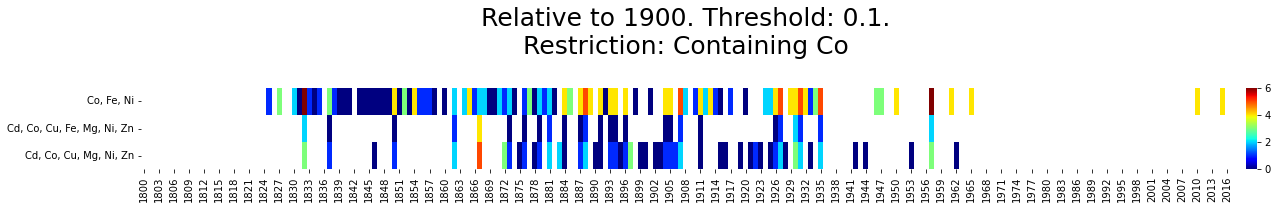

In [606]:
%%time
HeatmapClosure(year_relat,     
               incl_ce = {'Co'},
               #notincl_ce = {''}, 
               thresh_relev=0.1,)

## Calc a relevancy descriptor relative to each year, for each FE.

In [506]:
FEs_df = pd.DataFrame()
for y in range(1800,2022):
    for fe in FEs[y]:
        FEs_df.loc[str(sorted(fe)),y] = 1

FEs_df = (FEs_df
          .replace(np.nan,0)
          .cumsum(axis=1)
          .sort_values(2021))

# Filter: Consider only FEs that have been found more than only once in history.
FEs_df = FEs_df[FEs_df[2021]>1]

# Clean names (remove ], [, and ')
FEs_df.index = FEs_df.index.str.replace("]|\[|'","",regex=True) 

# Get year of newest element for each FE
elem_yr = pd.Series(3000,index=elemList)
FEs_df["yr_find_FE"] = 3000

for y in range(1800,2022):
    # List of CEs existing in year `yr`
    subs_elems = np.array(elemList)[simMat_yr[y-min_yr].sum(axis=0)>0]
        
    # Update CEs that exist in year `y`, but current reported year is > `y`
    elem_yr[(elem_yr.index.isin(subs_elems)) & (elem_yr>y)] = y
        
    # Add year of first appearence for each FE.
    FE_yr = list(map(lambda x: re.sub("'|\[|]","", str(sorted(x))) , FEs[y]))
    FEs_df.loc[FEs_df.index.isin(FE_yr) &
               (FEs_df["yr_find_FE"]>y),"yr_find_FE"] = y  
    
# Map year information to each set, and select max year
FEs_df['yr_newest_elem'] = (FEs_df.index.to_series()
                            .str.split(', ')
                            .apply(lambda x: elem_yr[x].values.max()))
   


# Difference between each year, and year of discovery of latest CE in each FE.
denom = (np.arange(1800,2022)[np.newaxis] - FEs_df.yr_newest_elem.values[:,np.newaxis])
denom*(denom>=0)  # Only count positive values.

# This division yields historical relevance for each FE, relative to each year.
hist_relev = FEs_df.loc[:,1800:2021]/(denom*(denom>=0)+1)

In [588]:
def PlotHistoricalRelev(incl_ce=False, 
                        notincl_ce=False,thresh=0.1):
    """
    Plot historical relevance for each FE, as a function of time.
        Consider only FEs containing all CEs in `incl_ce`.
                 only FEs containing none of the CEs in `notincl_ce`.
                 only FEs whose Historical Relevance is > `thresh` at some point in history.
    """
    relev = hist_relev.copy()
    
    # Filter results to only those containing elems in `incl_ce`
    if incl_ce:
        relev = relev[(relev
                       .index.to_series()
                       .apply(lambda x: (set(x.split(', '))
                                         .issuperset(incl_ce))
                             )
                      )]

    # Filter results to include only FEs NOT containing elems in `notincl_ce`
    if notincl_ce:
        relev = relev[(relev
                       .index.to_series()
                       .apply(lambda x: (not set(x.split(', '))
                                         .issuperset(notincl_ce))
                             )
                      )]


    relev = (relev
             .sort_values(2021,ascending=False))

    
    N=relev.shape[0]
    fig,ax=plt.subplots(N,1,figsize=(17,N*1.2),sharex=True,gridspec_kw={"hspace":0.3})

    for num,i in enumerate(relev.index):
        relev.columns = range(1800,2022)
        ax[num].plot(relev.loc[i],color='b')

        min_yr = relev.loc[i,~relev.loc[i].isna()].index.min()
        y_text = (relev.loc[i,2021])

        
        ax[num].text(2022,y_text,relev.loc[i].name,fontsize=20,rotation=0)

        for _ in ['top','left','right']:    ax[num].spines[_].set_visible(False);
        ax[num].set_yticks([])
        ax[num].grid("x")

        ax[num].set_ylabel(num+1)
        #ax[num].set_ylim(0,1.05)
        ax[num].set_ylabel('')

    ax[num].set_xlim(1800,2022);

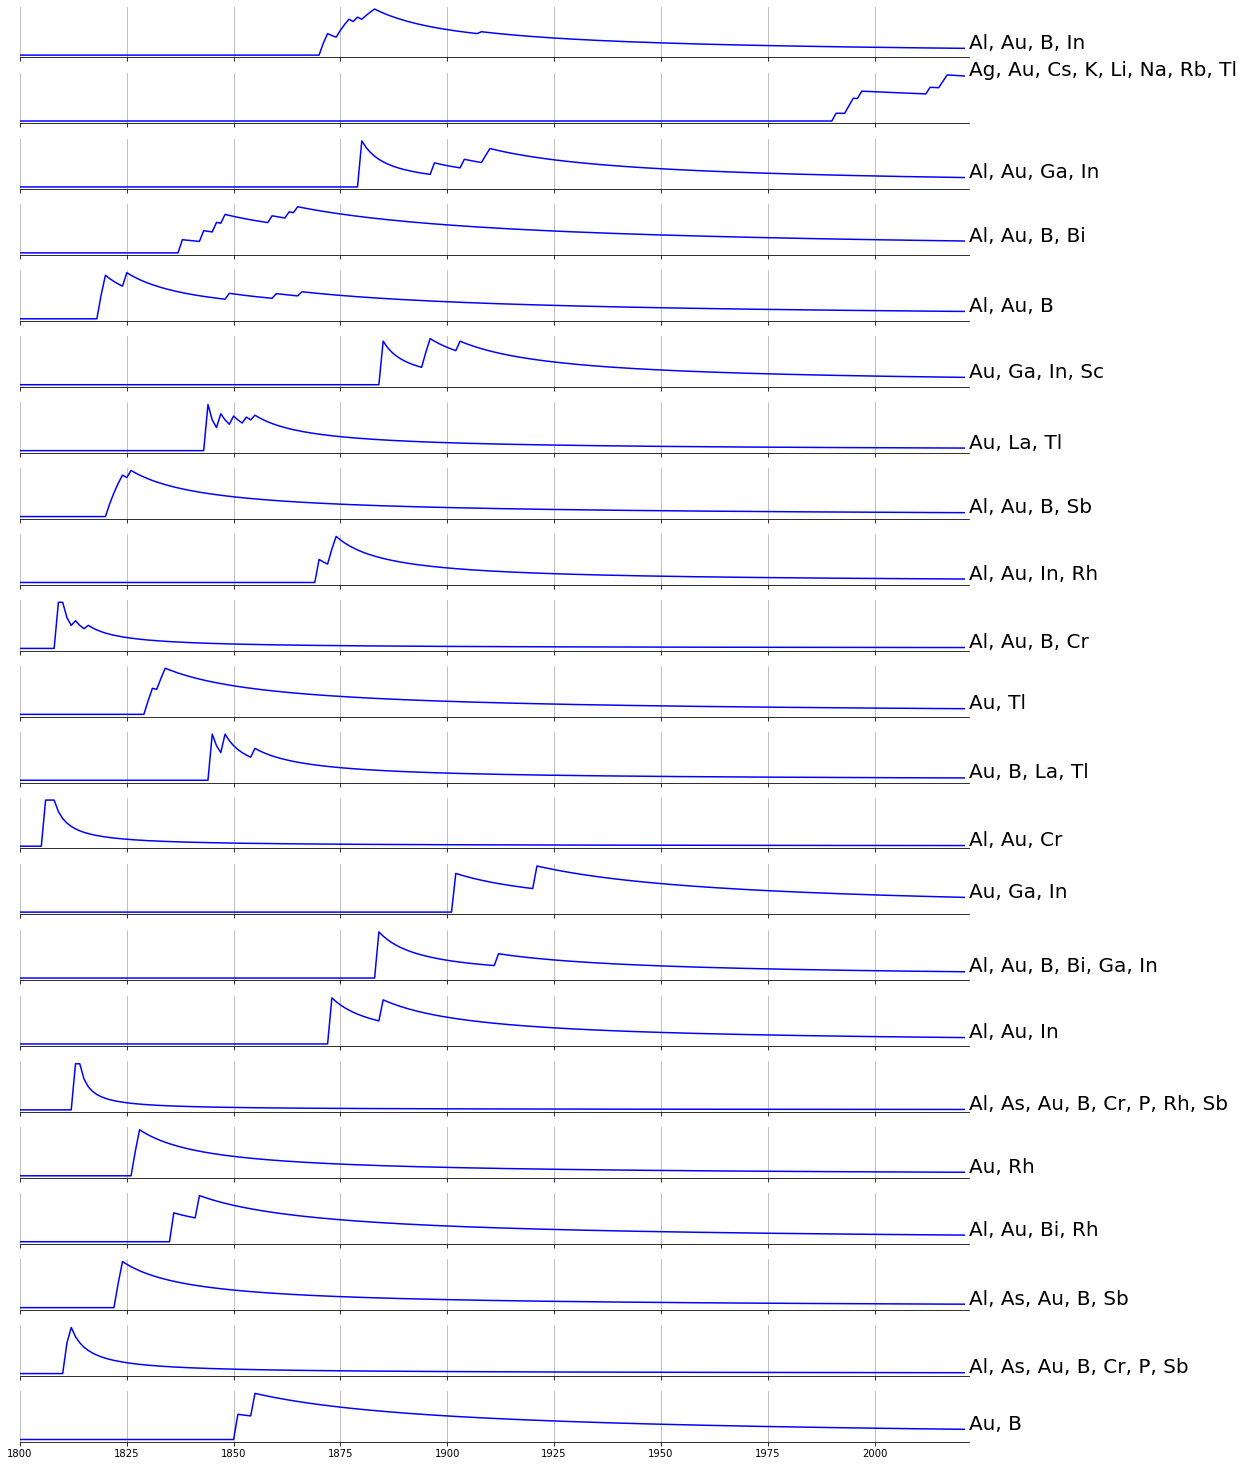

In [589]:
PlotHistoricalRelev(incl_ce = {'Au'},
                    thresh=0.)
#                    notincl_ce = {'H'})

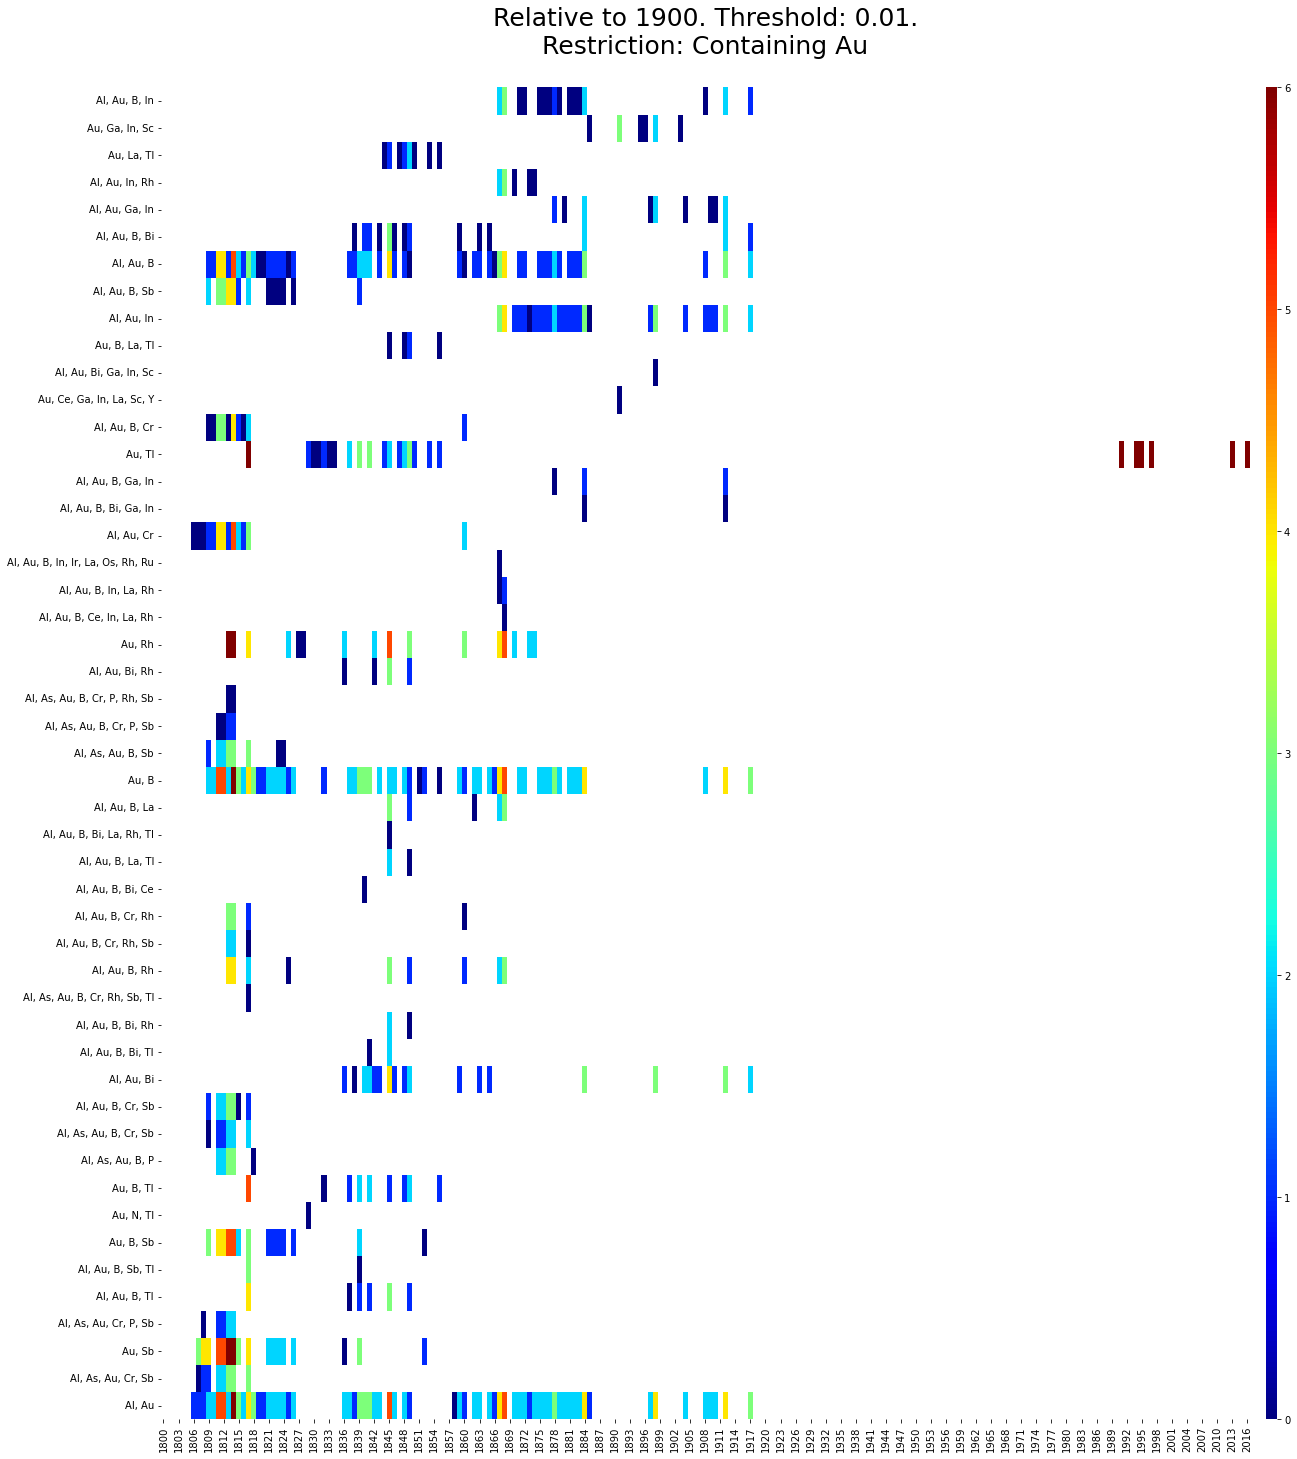

In [610]:
HeatmapClosure(year_relat, 
               incl_ce={'Au'}, 
               notincl_ce=False, 
               thresh_relev = 0.01, 
               relev = "percent_max_elem",)

In [615]:
a = np.exp(-np.arange(0,40)/10)

a/a.sum()

array([0.09693806, 0.08771319, 0.07936617, 0.07181348, 0.06497953,
       0.05879591, 0.05320074, 0.04813802, 0.04355708, 0.03941208,
       0.03566152, 0.03226788, 0.02919718, 0.0264187 , 0.02390463,
       0.02162981, 0.01957146, 0.01770899, 0.01602375, 0.01449889,
       0.01311914, 0.01187069, 0.01074104, 0.0097189 , 0.00879402,
       0.00795716, 0.00719994, 0.00651477, 0.00589481, 0.00533384,
       0.00482626, 0.00436698, 0.00395141, 0.00357538, 0.00323514,
       0.00292728, 0.00264871, 0.00239665, 0.00216858, 0.00196221])